In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()
# 3) If you’re using PyTorch + CUDA, free any lingering GPU memory
import torch
torch.cuda.empty_cache()

import importlib
from libs import models, plots, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)

import pandas as pd
import numpy  as np
import math

import datetime as dt
from datetime import datetime

import copy
from typing import Sequence, List, Tuple, Optional, Union

from tqdm.auto import tqdm

import torch.nn as nn
import torch.nn.functional as Funct
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
ticker         = params.ticker
LOOK_BACK      = params.look_back 
features_cols  = params.features_cols
label_col      = params.label_col

date = datetime.now().strftime("%Y-%m-%d %H:%M")
regular_start      = params.regular_start_pred

# dataset split proportions
TRAIN_PROP, VAL_PROP = params.train_prop, params.val_prop

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

###############################################################################
# 1 · MODEL HYPER-PARAMETERS (attention-augmented tuned defaults)
###############################################################################

# ── Architecture Parameters ───────────────────────────────────────────────
SHORT_UNITS         = 32           # hidden size of each daily LSTM layer
LONG_UNITS          = 64          # hidden size of the weekly LSTM
DROPOUT_SHORT       = 0.3          # dropout after residual+attention block
DROPOUT_LONG        = 0.5          # dropout after weekly LSTM outputs
ATT_HEADS           = 4            # number of self-attention heads
ATT_DROPOUT         = 0.2          # dropout rate inside attention
WEIGHT_DECAY        = 1e-3         # L2 weight decay on all model weights

# ── Training Control Parameters ────────────────────────────────────────────
TRAIN_BATCH         = params.train_batch           
VAL_BATCH           = params.val_batch  
NUM_WORKERS         = params.num_workers
MAX_EPOCHS          = 200          # upper limit on training epochs
EARLY_STOP_PATIENCE = 20           # stop if no val-improve for this many epochs

# ── Optimizer Settings ─────────────────────────────────────────────────────
INITIAL_LR          = 1e-3         # AdamW initial learning rate
CLIPNORM            = 0.3          # max-norm gradient clipping

# ── ReduceLROnPlateau Scheduler ───────────────────────────────────────────
PLATEAU_FACTOR      = 0.5          # multiply LR by this factor on plateau
PLATEAU_PATIENCE    = 2            # epochs with no val-improve before LR cut
MIN_LR              = 1e-5         # lower bound on LR after reductions

# ── CosineAnnealingWarmRestarts Scheduler ─────────────────────────────────
T_0                 = 2            # epochs before first cosine restart
T_MULT              = 2            # cycle length multiplier after each restart
ETA_MIN             = MIN_LR       # floor LR in each cosine cycle


Using device: cuda


In [4]:
# FEATURES ENGINEERING

df = pd.read_csv(f"dfs training/{ticker}_ready.csv", index_col=0, parse_dates=True)

# 1) engineer top intraday features on your 1-min bars
for lag in (1, 5, 15):
    df[f"r_{lag}"] = np.log(df["close"] / df["close"].shift(lag))

df["vol_15"]        = df["r_1"].rolling(15).std()
df["volume_spike"]  = df["volume"] / df["volume"].rolling(15).mean()

typ_price = (df["high"] + df["low"] + df["close"]) / 3
vwap      = (typ_price * df["volume"]).cumsum() / df["volume"].cumsum()
df["vwap_dev"]      = (df["close"] - vwap) / vwap

delta     = df["close"].diff()
gain      = delta.clip(lower=0)
loss      = -delta.clip(upper=0)
avg_gain  = gain.rolling(14).mean()
avg_loss  = loss.rolling(14).mean()
rs        = avg_gain / avg_loss
df["rsi_14"]        = 100 - (100 / (1 + rs))

# 2) keep only your label plus the most predictive features

df = df[features_cols  + ['bid', 'ask'] + [label_col]].dropna()

print("\n Step D: saving final CSV …")
out_path = f"dfs training/{ticker}_final.csv"
df.to_csv(out_path)
df


 Step D: saving final CSV …


,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bid,ask,signal_smooth
2014-04-03 12:06:00,28.644845,28.644845,28.644845,28.644845,4580.0,-0.000180,-0.000180,-0.000180,0.000046,0.568641,-0.000177,0.000000,28.636251,28.653438,0.327384
2014-04-03 12:07:00,28.639690,28.639690,28.639690,28.639690,4540.0,-0.000180,-0.000360,-0.000360,0.000063,0.570338,-0.000352,0.000000,28.631098,28.648282,0.328556
2014-04-03 12:08:00,28.634534,28.634534,28.634534,28.634534,4500.0,-0.000180,-0.000540,-0.000540,0.000075,0.574408,-0.000524,0.000000,28.625944,28.643125,0.329833
2014-04-03 12:09:00,28.629379,28.629379,28.629379,28.629379,4460.0,-0.000180,-0.000720,-0.000720,0.000082,0.581017,-0.000694,0.000000,28.620791,28.637968,0.331213
2014-04-03 12:10:00,28.624224,28.624224,28.624224,28.624224,4420.0,-0.000180,-0.000900,-0.000900,0.000088,0.590413,-0.000862,0.000000,28.615637,28.632811,0.332697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375000,173.677100,173.215000,173.565000,621199.0,0.001124,-0.004226,-0.009661,0.001493,2.462713,1.248428,17.019768,173.512900,173.617100,0.000000
2025-06-18 20:57:00,173.565000,173.590000,173.240000,173.380000,624198.0,-0.001066,-0.005063,-0.010671,0.001487,2.154838,1.246015,11.648165,173.328000,173.432000,0.000000
2025-06-18 20:58:00,173.390000,173.410000,173.200000,173.310000,454542.0,-0.000404,-0.005811,-0.011816,0.001436,1.439161,1.245096,11.384870,173.258000,173.362000,0.000000
2025-06-18 20:59:00,173.315000,173.400000,173.230000,173.280000,1094746.0,-0.000173,-0.004434,-0.011932,0.001432,2.836382,1.244678,11.830567,173.228000,173.332000,0.000000


In [5]:
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=LOOK_BACK,
    features_cols=features_cols,
    label_col=label_col,
    regular_start=regular_start
)

# 1)
print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) 


# 2) quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, features, look_back)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

# 3) rebuild the list of label‐timestamps (window‐ends)
ends = []
for day, day_df in df.groupby(df.index.normalize(), sort=False):
    day_df = day_df.sort_index()
    # candidate ends at positions look_back .. end
    idxs = day_df.index[LOOK_BACK:]
    # only keep those at/after regular_start
    mask = [t >= regular_start for t in idxs.time]
    ends.extend(idxs[mask])

# 4) show first few ends
print("\nFirst 5 window‐end timestamps:")
for ts in ends[:5]:
    print(" ", ts)

# 5) show exactly which minutes X[0] contains
first_end   = ends[0]
first_start = first_end - pd.Timedelta(minutes=LOOK_BACK)
print(f"\nFirst window covers {LOOK_BACK} bars from")
print(f"  {first_start}  →  {first_end - pd.Timedelta(minutes=1)}")
print(f"and predicts the bar at {first_end}")

print("\nThose bars (timestamps):")
print(pd.date_range(first_start, first_end - pd.Timedelta(minutes=1), freq="1min"))
# -------------------------------------------------------------------

y_np         = y.cpu().numpy()
print("First 5 values y:",         y_np[:5])
print("First 5 signal_smooth values, on regular trade time:")
df.signal_smooth.iloc[LOOK_BACK:LOOK_BACK+5]

torch.Size([1313759, 12, 120])
torch.Size([1313759])
Shapes:
  X         = torch.Size([1313759, 12, 120]) (samples, features, look_back)
  y         = torch.Size([1313759]) (samples,)
  raw_close = torch.Size([1313759])
  raw_bid   = torch.Size([1313759])
  raw_ask   = torch.Size([1313759])

First 5 window‐end timestamps:
  2014-04-03 14:06:00
  2014-04-03 14:07:00
  2014-04-03 14:08:00
  2014-04-03 14:09:00
  2014-04-03 14:10:00

First window covers 120 bars from
  2014-04-03 12:06:00  →  2014-04-03 14:05:00
and predicts the bar at 2014-04-03 14:06:00

Those bars (timestamps):
DatetimeIndex(['2014-04-03 12:06:00', '2014-04-03 12:07:00',
               '2014-04-03 12:08:00', '2014-04-03 12:09:00',
               '2014-04-03 12:10:00', '2014-04-03 12:11:00',
               '2014-04-03 12:12:00', '2014-04-03 12:13:00',
               '2014-04-03 12:14:00', '2014-04-03 12:15:00',
               ...
               '2014-04-03 13:56:00', '2014-04-03 13:57:00',
               '2014-04-03 13:

2014-04-03 14:06:00    0.388062
2014-04-03 14:07:00    0.388300
2014-04-03 14:08:00    0.388634
2014-04-03 14:09:00    0.389049
2014-04-03 14:10:00    0.389303
Name: signal_smooth, dtype: float64

In [6]:
# Split into train/val/test by calendar day
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = LOOK_BACK,
    regular_start   = regular_start,
    train_prop  = TRAIN_PROP,
    val_prop    = VAL_PROP,
    train_batch = TRAIN_BATCH
)

# 1) Print shapes of all tensors
print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)

# 2) Print number of days in each split
n_tr_days = torch.unique(day_id_tr).numel()
n_val_days= torch.unique(day_id_val).numel()
n_te_days = torch.unique(day_id_te).numel()
print(f"\nDays: train={n_tr_days}, val={n_val_days}, test={n_te_days}")

# 3) Print number of windows in each split
print(f"Windows: train={X_tr.shape[0]}, val={X_val.shape[0]}, test={X_te.shape[0]}")

# 4) List the first few window‐end timestamps
ends = []
for day, day_df in df.groupby(df.index.normalize(), sort=False):
    ts = day_df.index[LOOK_BACK:]
    ends.extend(ts[ts.time >= regular_start])
first_ends = ends[:5]
print("\nFirst 5 window‐end times:", first_ends)

# 5) Show exactly which minutes X_tr[0] covers, and where y_tr[0] sits
first_end   = first_ends[0]
first_start = first_end - pd.Timedelta(minutes=LOOK_BACK)
# input bars = [first_start … first_end − 1min]
print(f"\nX_tr[0] covers bars from {first_start} to {first_end - pd.Timedelta(minutes=1)}")
print("Those timestamps:")
print(pd.date_range(first_start, first_end - pd.Timedelta(minutes=1), freq="1min"))
print(f"y_tr[0] (and raw_close_te[0]) is the bar at {first_end}")



Shapes:
  X_tr        = torch.Size([891515, 12, 120])
  y_tr        = torch.Size([891515])
  raw_close_te= torch.Size([215633])
  raw_bid_te  = torch.Size([215633])
  raw_ask_te  = torch.Size([215633])

Days: train=1984, val=410, test=422
Windows: train=891515, val=206611, test=215633

First 5 window‐end times: [Timestamp('2014-04-03 14:06:00'), Timestamp('2014-04-03 14:07:00'), Timestamp('2014-04-03 14:08:00'), Timestamp('2014-04-03 14:09:00'), Timestamp('2014-04-03 14:10:00')]

X_tr[0] covers bars from 2014-04-03 12:06:00 to 2014-04-03 14:05:00
Those timestamps:
DatetimeIndex(['2014-04-03 12:06:00', '2014-04-03 12:07:00',
               '2014-04-03 12:08:00', '2014-04-03 12:09:00',
               '2014-04-03 12:10:00', '2014-04-03 12:11:00',
               '2014-04-03 12:12:00', '2014-04-03 12:13:00',
               '2014-04-03 12:14:00', '2014-04-03 12:15:00',
               ...
               '2014-04-03 13:56:00', '2014-04-03 13:57:00',
               '2014-04-03 13:58:00', '2014-

In [7]:

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=TRAIN_BATCH,
    train_workers=NUM_WORKERS
)


▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=891515, val=206611, te=215633
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..409], total days=410
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 410
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready


In [8]:

def make_optimizer_and_scheduler(
    model: nn.Module,
    initial_lr: float,
    weight_decay: float = 1e-3,
    lr_reduce_factor: float = 0.5,
    lr_patience: int = 3,
    lr_min: float = 1e-6,
    clipnorm: float = 0.5,
):
    """
    Build optimizer, LR scheduler, AMP scaler, and clipping threshold.

    • optimizer: AdamW with L2 weight_decay on all non‐bias weights.
    • plateau_sched: ReduceLROnPlateau – watches val‐RMSE, cuts LR when plateau.
      - mode='min'       → lower-is-better metric (we minimize RMSE).
      - factor=0.5       → multiply LR by 0.5 on plateau.
      - patience=3       → wait 3 epochs with no improvement before cutting.
      - min_lr=1e-6      → never drop below this learning rate.
      - verbose=True     → print a message whenever LR is reduced.
    • scaler: GradScaler for mixed‐precision (automatically handles device).
    • clipnorm: float threshold for gradient clipping in train_step.

    Returns:
      optimizer, plateau_sched, scaler, clipnorm
    """
    # 1) AdamW: adaptive moment optimizer with decoupled weight decay
    optimizer = AdamW(
        model.parameters(),
        lr=initial_lr,
        weight_decay=weight_decay
    )

    # 2) ReduceLROnPlateau: only reduces LR when val metric plateaus
    plateau_sched = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_reduce_factor,
        patience=lr_patience,
        min_lr=lr_min,
        verbose=True
    )

    cosine_sched  = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=T_0, 
        T_mult=T_MULT, 
        eta_min=ETA_MIN
    )

    # 3) GradScaler: handles loss scaling for mixed precision
    scaler = GradScaler()

    # Return all four objects; clipnorm passed through to train_step
    return optimizer, plateau_sched, cosine_sched, scaler, clipnorm



def train_step(
    model:     nn.Module,
    x_day:     torch.Tensor,            # shape (W, look_back, F), already on device
    y_day:     torch.Tensor,            # shape (W,),            already on device
    optimizer: torch.optim.Optimizer,
    scaler:    GradScaler,
    clipnorm:  float,
) -> float:
    """
    Perform one mixed‐precision training update for a single “day” of data.

    Steps:
      1. Zero gradients (`optimizer.zero_grad(set_to_none=True)`).
      2. Forward in fp16 context:
         - autocast on x_day.device
         - model(x_day) → out shape (W, seq_len, 1)
         - extract last step: out[:, -1, 0] → (W,)
         - compute MSE loss against y_day
      3. Backward:
         - scaler.scale(loss).backward()
         - scaler.unscale_(optimizer) to prepare for clipping
         - clip gradients to `clipnorm`
         - scaler.step(optimizer) + scaler.update()
      4. Return float(loss)

    Returns:
      The scalar loss value (Python float) for logging.
    """
    # 1) Reset gradients
    optimizer.zero_grad(set_to_none=True)
    model.train()

    # 2) Mixed‐precision forward
    device = x_day.device
    with autocast(device_type=device.type):
        out = model(x_day)            # → (W, seq_len, 1)
        last = out[:, -1, 0]          # → (W,)
        loss = Funct.mse_loss(last, y_day, reduction='mean')

    # 3) Backward with gradient scaling and clipping
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)        # bring gradients back to fp32 for clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipnorm)
    scaler.step(optimizer)
    scaler.update()

    return loss.item()


def get_current_lr(optimizer: torch.optim.Optimizer) -> float:
    """
    Retrieve the current learning rate from the first parameter group.
    """
    return float(optimizer.param_groups[0]['lr'])


In [9]:

def custom_stateful_training_loop(
    model:         torch.nn.Module,
    optimizer:     torch.optim.Optimizer,
    cosine_sched:  torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    plateau_sched: torch.optim.lr_scheduler.ReduceLROnPlateau,
    scaler:        torch.cuda.amp.GradScaler,
    train_loader:  torch.utils.data.DataLoader,
    val_loader:    torch.utils.data.DataLoader,
    *,
    max_epochs:          int,
    early_stop_patience: int,
    baseline_val_rmse:   float,
    clipnorm:            float,
    device:              torch.device
) -> float:
    """
    Stateful LSTM Training Loop with:
      - Mixed‐precision (AMP)
      - Per‐day hidden‐state resets
      - CosineWarmRestarts (per‐batch) + ReduceLROnPlateau (per‐epoch)
      - Early stopping + live RMSE plot
      - Extra GPU‐cache clears & memory logs to prevent silent OOMs
    """

    model.to(device)
    torch.backends.cudnn.benchmark = True

    best_val_rmse = float('inf')
    best_state    = None
    patience_ctr  = 0

    save_path = params.save_path
    save_path.mkdir(parents=True, exist_ok=True)
    live_plot = plots.LiveRMSEPlot()

    for epoch in range(1, max_epochs + 1):
        # ─── PRE‐EPOCH: clear and log memory ─────────────────────────────
        # torch.cuda.empty_cache()
        gc.collect()
        print(f"[Epoch {epoch}] GPU alloc = {torch.cuda.memory_allocated(device)/1e9:.2f} GB")

        # ─── TRAIN PHASE ─────────────────────────────────────────────────
        model.train()
        model.h_short = model.h_long = None
        train_losses = []

        pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"Epoch {epoch}",
            unit="bundle"
        )

        for batch_idx, (xb_days, yb_days, wd_days) in pbar:
            # Move one bundle of days to GPU
            xb_days = xb_days.to(device, non_blocking=True)
            yb_days = yb_days.to(device, non_blocking=True)
            wd_days = wd_days.to(device)

            # Zero grads once per bundle
            optimizer.zero_grad(set_to_none=True)

            prev_wd = None

            for di in range(xb_days.size(0)):
                wd = int(wd_days[di].item())

                # Reset states
                model.reset_short()
                if prev_wd is not None and wd < prev_wd:
                    model.reset_long()
                prev_wd = wd

                # Autocast forward/backward
                with torch.cuda.amp.autocast():
                    out  = model(xb_days[di])       # -> (W, look_back, 1)
                    last = out[..., -1, 0]          # -> (W,)
                    loss = Funct.mse_loss(last, yb_days[di], reduction='mean')

                scaler.scale(loss).backward()
                train_losses.append(loss.item())

                # Detach hidden‐state to trim graph
                if isinstance(model.h_short, tuple):
                    model.h_short = tuple(h.detach() for h in model.h_short)
                if isinstance(model.h_long, tuple):
                    model.h_long = tuple(h.detach() for h in model.h_long)

                # free per‐day intermediates
                del out, last, loss

            # Unscale, clip, step & update scaler
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clipnorm)
            scaler.step(optimizer)
            scaler.update()

            # Cosine scheduler step (fractional epoch)
            frac_epoch = epoch - 1 + batch_idx / len(train_loader)
            cosine_sched.step(frac_epoch)

            # Log bundle RMSE & LR
            rmse = math.sqrt(sum(train_losses) / len(train_losses))
            lr   = optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_rmse=rmse, lr=lr, refresh=False)
            pbar.update(0)

            # Clear bundle tensors & cache
            del xb_days, yb_days, wd_days
            # torch.cuda.empty_cache()
            gc.collect()

        pbar.close()

        # ─── VALIDATION PHASE ─────────────────────────────────────────────
        model.eval()
        model.h_short = model.h_long = None
        val_losses = []
        prev_wd    = None

        with torch.no_grad():
            for xb_day, yb_day, wd in val_loader:
                wd = int(wd.item())
                x  = xb_day[0].to(device, non_blocking=True)
                y  = yb_day.view(-1).to(device, non_blocking=True)

                model.reset_short()
                if prev_wd is not None and wd < prev_wd:
                    model.reset_long()
                prev_wd = wd

                out  = model(x)
                last = out[..., -1, 0]
                val_losses.append(Funct.mse_loss(last, y, reduction='mean').item())

                del xb_day, yb_day, x, y, out, last
                # torch.cuda.empty_cache()

        val_rmse = math.sqrt(sum(val_losses) / len(val_losses))

        # ─── LOG & SCHEDULERS ─────────────────────────────────────────────
        live_plot.update(rmse, val_rmse)
        print(f"Epoch {epoch:03d} • train={rmse:.4f} • val={val_rmse:.4f} • lr={optimizer.param_groups[0]['lr']:.2e}")

        # ReduceLROnPlateau
        pre_lr = optimizer.param_groups[0]['lr']
        plateau_sched.step(val_rmse)
        post_lr = optimizer.param_groups[0]['lr']
        if post_lr < pre_lr:
            print(f"Plateau reduced LR: {pre_lr:.1e} → {post_lr:.1e} at epoch {epoch}")

        # Early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_state    = copy.deepcopy(model.state_dict())
            patience_ctr  = 0
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping triggered at epoch", epoch)
                break

    # ─── SAVE BEST MODEL ─────────────────────────────────────────────────
    if best_state is not None:
        model.load_state_dict(best_state)

    ckpt_file = save_path / f"{ticker}_{best_val_rmse:.4f}.pth"
    torch.save(model, ckpt_file)
    print(f"Saved best model (val RMSE={best_val_rmse:.4f}) to {ckpt_file}")

    return best_val_rmse


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training sees 1984 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.535586


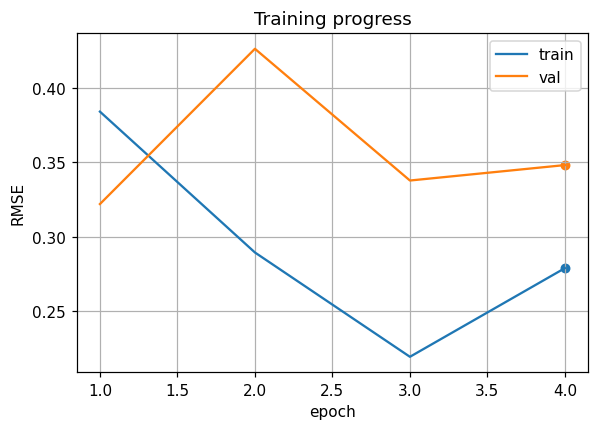

[Epoch 1] GPU alloc = 0.00 GB


/tmp/ipykernel_807/4215409556.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 31/31 [00:33<00:00,  1.08s/bundle, lr=0.00053, train_rmse=0.384] 


Epoch 001 • train=0.3842 • val=0.3221 • lr=5.30e-04
[Epoch 2] GPU alloc = 0.02 GB


Epoch 2: 100%|██████████| 31/31 [00:29<00:00,  1.04bundle/s, lr=1.06e-5, train_rmse=0.29]  


Epoch 002 • train=0.2895 • val=0.4264 • lr=1.06e-05
[Epoch 3] GPU alloc = 0.02 GB


Epoch 3: 100%|██████████| 31/31 [00:29<00:00,  1.05bundle/s, lr=0.000864, train_rmse=0.219]


Epoch 003 • train=0.2194 • val=0.3379 • lr=8.64e-04
[Epoch 4] GPU alloc = 0.02 GB


Epoch 4: 100%|██████████| 31/31 [00:30<00:00,  1.03bundle/s, lr=0.000518, train_rmse=0.279]


Epoch 004 • train=0.2790 • val=0.3482 • lr=5.18e-04
Plateau reduced LR: 5.2e-04 → 2.6e-04 at epoch 4
[Epoch 5] GPU alloc = 0.02 GB


Epoch 5:  65%|██████▍   | 20/31 [00:20<00:10,  1.04bundle/s, lr=0.000276, train_rmse=0.19] 

In [ ]:
N_FEATS = len(features_cols)

# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = N_FEATS,        # number of input features per minute
    short_units    = SHORT_UNITS,    # hidden size of daily LSTM
    long_units     = LONG_UNITS,     # hidden size of weekly LSTM
    dropout_short  = DROPOUT_SHORT,  # dropout after daily LSTM
    dropout_long   = DROPOUT_LONG,    # dropout after weekly LSTM
    att_heads      = ATT_HEADS,
    att_drop       = ATT_DROPOUT
)
model.to(device)   # place model parameters on GPU or CPU as specified


# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = make_optimizer_and_scheduler(
    model,
    initial_lr         = INITIAL_LR,         # starting learning rate, e.g. 3e-4
    weight_decay       = WEIGHT_DECAY,       # L2 penalty on all weights
    lr_reduce_factor   = PLATEAU_FACTOR,     # multiply LR by IT on plateau
    lr_patience        = PLATEAU_PATIENCE,   # epochs with no val‐improve before reduce
    lr_min             = MIN_LR,             # lower bound on LR
    clipnorm           = CLIPNORM            # max gradient‐norm before clipping
)


# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")


# -----------------------------------------------------------------------------
# Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")


# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse = custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = MAX_EPOCHS,
    early_stop_patience = EARLY_STOP_PATIENCE,
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device      # torch.device('cuda') or 'cpu'
)


# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
